In [1]:
OBJECT = "science"  # science or DIA
IMG = "diff"  # cal or diff
PHOT = "PSF"  # PSF
MODE = "forced"  # forced

BANDS = "ugrizy"  # subset of `ugrizy`

In [2]:
from pathlib import Path

import lsdb
import numpy as np
import pandas as pd
from dask.distributed import print as dask_print
from dask.distributed import Client
from nested_pandas import NestedFrame

from whitening import whiten_data

In [3]:
import nested_pandas

nested_pandas.__version__

'0.5.0'

In [4]:
dp1_root = Path("/ocean/projects/phy210048p/shared/hats/catalogs/dp1.py")

In [5]:
match OBJECT:
    case "science":
        catalog_name = "object_collection"
        id_col = "objectId"

match MODE, OBJECT:
    case "forced", "science":
        source_col = "objectForcedSource"
    case _:
        raise NotImplementedError(f"MODE '{MODE}' and OBJECT '{OBJECT}' are not supported")

match IMG:
    case "cal":
        phot_col_prefix = "psf"
    case "diff":
        phot_col_prefix = "psfDiff"
    case _:
        raise NotImplementedError(f"IMG '{IMG}' is not supported")

flux_col = f"{phot_col_prefix}Flux"
flux_err_col = f"{flux_col}Err"
flux_flag_col = f"{flux_col}_flag"

obj_mag_cols = [f"{band}_psfMag" for band in BANDS]

other_flag_cols = [
    "pixelFlags_suspect",
    "pixelFlags_saturated",
    "pixelFlags_cr",
    "pixelFlags_bad",
]

In [6]:
dp1_object = lsdb.open_catalog(
    dp1_root / catalog_name,
    columns=[
        id_col,
        f"{source_col}.band",
        f"{source_col}.{flux_col}",
        f"{source_col}.{flux_err_col}",
        f"{source_col}.{flux_flag_col}",
    ]
    + [f"{source_col}.{flag_col}" for flag_col in other_flag_cols]
    + obj_mag_cols,
)

dp1_object

,objectId,u_psfMag,g_psfMag,r_psfMag,i_psfMag,z_psfMag,y_psfMag,coord_ra,coord_dec,objectForcedSource
npartitions=389,,,,,,,,,,
"Order: 6, Pixel: 130",int64[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],double[pyarrow],double[pyarrow],"nested<band: [string], psfDiffFlux: [float], p..."
"Order: 8, Pixel: 2176",...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...
"Order: 9, Pixel: 2302101",...,...,...,...,...,...,...,...,...,...
"Order: 7, Pixel: 143884",...,...,...,...,...,...,...,...,...,...


In [7]:
with Client(n_workers=16, threads_per_worker=1) as client:
    result = dp1_object["u_psfMag"].min().compute()
result

12.627201080322266

In [8]:
def filter_bad_obs(df, *, lc_col, flag_cols):
    expr = " and ".join(f"~{lc_col}.{flag_col}" for flag_col in flag_cols)
    return df.query(expr)


def repack_by_band(df, *, ident_col, lc_col):
    # Nested columns for the result dataframe, which has monochromatic light curves
    nested_columns = list(df[lc_col].dtype.fields)
    nested_columns.remove("band")

    df = df.explode(lc_col)

    # Create a unique index values per object per band
    df = df.reset_index(drop=False)
    if len(df) == 0:
        df["objectBandId"] = np.array([], dtype=int)
    else:
        df["objectBandId"] = np.array(
            df.apply(lambda row: hash((row[ident_col], row["band"])), axis=1), dtype=int
        )
    base_columns = [col for col in df.columns if col not in nested_columns and col != "objectBandId"]
    df = NestedFrame.from_flat(
        df,
        base_columns=base_columns,
        nested_columns=nested_columns,
        on="objectBandId",
        name="lc",
    )
    if "_healpix_29" not in df.columns:
        raise ValueError(f"{df.columns = }")
    # Move that new objectIdBand index back to columns, replace with the original index
    return df.reset_index(drop=False).set_index("_healpix_29")


def filter_nobs(df, lc_col, min_nobs):
    counts = df[lc_col].nest.list_lengths
    return df[counts >= min_nobs]


def add_whiten_z(df, lc_col, x_col, err_col):
    if len(df) == 0:
        z = np.array([], dtype=float)
    else:
        tmp = df.reduce(
            lambda x, err: {"tmp.z": whiten_data(x, err)},
            f"{lc_col}.{x_col}",
            f"{lc_col}.{err_col}",
        )
        assert len(tmp) == len(df), f"{len(tmp)} != {len(df)}"
        assert tmp["tmp"].nest.flat_length == df[lc_col].nest.flat_length
        z = tmp["tmp.z"]
    df[f"{lc_col}.z"] = z
    return df


def do_stuff(df, *, ident_col, lc_col, x_col, err_col, min_nobs, source_flag_cols):
    df = filter_bad_obs(df, lc_col=lc_col, flag_cols=source_flag_cols)
    df = repack_by_band(df, ident_col=ident_col, lc_col=lc_col)
    df = filter_nobs(df, "lc", min_nobs)
    df = add_whiten_z(df, "lc", x_col, err_col)
    return df


monochrome = dp1_object.map_partitions(
    do_stuff,
    ident_col=id_col,
    lc_col=source_col,
    x_col=flux_col,
    err_col=flux_err_col,
    source_flag_cols=[flux_flag_col] + other_flag_cols,
    min_nobs=10,
)
monochrome.head()

objectBandId            objectId  u_psfMag  \
_healpix_29                                                           
9575601502087759  5665129204422558557  648370805624800761      <NA>   
9575631103547827 -4379835599288278653  648370805624803169      <NA>   
9575631638058127  6069590231206456149  648370805624811333      <NA>   
9575631665686405 -1894702396483643809  648370805624811315      <NA>   
9575631681678992 -1567657284289953920  648370805624811310      <NA>   

                   g_psfMag   r_psfMag   i_psfMag   z_psfMag  y_psfMag  \
_healpix_29                                                              
9575601502087759  24.867653  24.680906  24.000395  23.125128      <NA>   
9575631103547827  26.845461  24.838604  25.895935       <NA>      <NA>   
9575631638058127   26.63364  24.781599  25.784842  24.846529      <NA>   
9575631665686405  24.836214  24.383066  23.560232  23.338715      <NA>   
9575631681678992  24.685595  23.268311  22.049849  21.555473      <NA>   

                   coord_ra  coord_dec band  \
_healpix_29                                   
9575601502087759  38.164028   6.261487    i   
9575631103547827  38.147743   6.265253    g   
9575631638058127  38.146416   6.266314    g   
9575631665686405  38.146481   6.266875    g   
9575631681678992  38.147164   6.266803    g   

                                                                 lc  
_healpix_29                                                          
9575601502087759  [{psfDiffFlux: -421.86084, psfDiffFluxErr: 314...  
9575631103547827  [{psfDiffFlux: -99.564232, psfDiffFluxErr: 136...  
9575631638058127  [{psfDiffFlux: 16.769693, psfDiffFluxErr: 136....  
9575631665686405  [{psfDiffFlux: -76.078819, psfDiffFluxErr: 137...  
9575631681678992  [{psfDiffFlux: 111.854378, psfDiffFluxErr: 138...

In [9]:
def compute_hist(z, *, bins):
    hist, _bins = np.histogram(z, bins=bins)
    return hist


def extract_hists(df, *, bins):
    if len(df) == 0:
        return NestedFrame.from_flat(pd.DataFrame({"count": []}), base_columns=[], name="hist")
    double_nested = NestedFrame.from_flat(
        df,
        base_columns=[],  # [col for col in nf.columns if col != 'lc'],
        nested_columns=["lc"],
        on="band",
        name="nested",
    )
    return double_nested.reduce(
        lambda nested: {"hist.count": compute_hist(NestedFrame(nested)["lc.z"], bins=bins)},
        "nested",
    )

In [10]:
bins = np.r_[-10:10:1001j]
width = bins[1] - bins[0]
centers = 0.5 * (bins[1:] + bins[:-1])

hists = monochrome.map_partitions(extract_hists, bins=bins)

In [11]:
with Client(n_workers=64, threads_per_worker=1, memory_limit=f"{256/32}GB") as client:
    display(client)
    hist_df = hists.compute()
hist_df.head(2)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 64
Total threads: 64,Total memory: 476.84 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38325,Workers: 64
Dashboard: http://127.0.0.1:8787/status,Total threads: 64
Started: Just now,Total memory: 476.84 GiB
Comm: tcp://127.0.0.1:34231,Total threads: 1
Dashboard: http://127.0.0.1:46349/status,Memory: 7.45 GiB
Nanny: tcp://127.0.0.1:45291,


hist
band                             
i     [{count: 0}; …] (1000 rows)
g     [{count: 0}; …] (1000 rows)

In [12]:
per_band_hist_df = hist_df.groupby(level=0)["hist"].apply(lambda df: sum(df))
per_band_hist_df

count
band           
g    0       57
     1       66
...         ...
z    998     37
     999     33

[6000 rows x 1 columns]

0.010460321679870987 1.4974494056494003
-0.00048534878885825306 1.1850052028244198
0.0005382364203144197 1.1384389936380745
0.00030366951304588996 1.0803547770805517
0.0003485422884637601 1.0728850061761286
0.003459821734930313 1.04838637482534


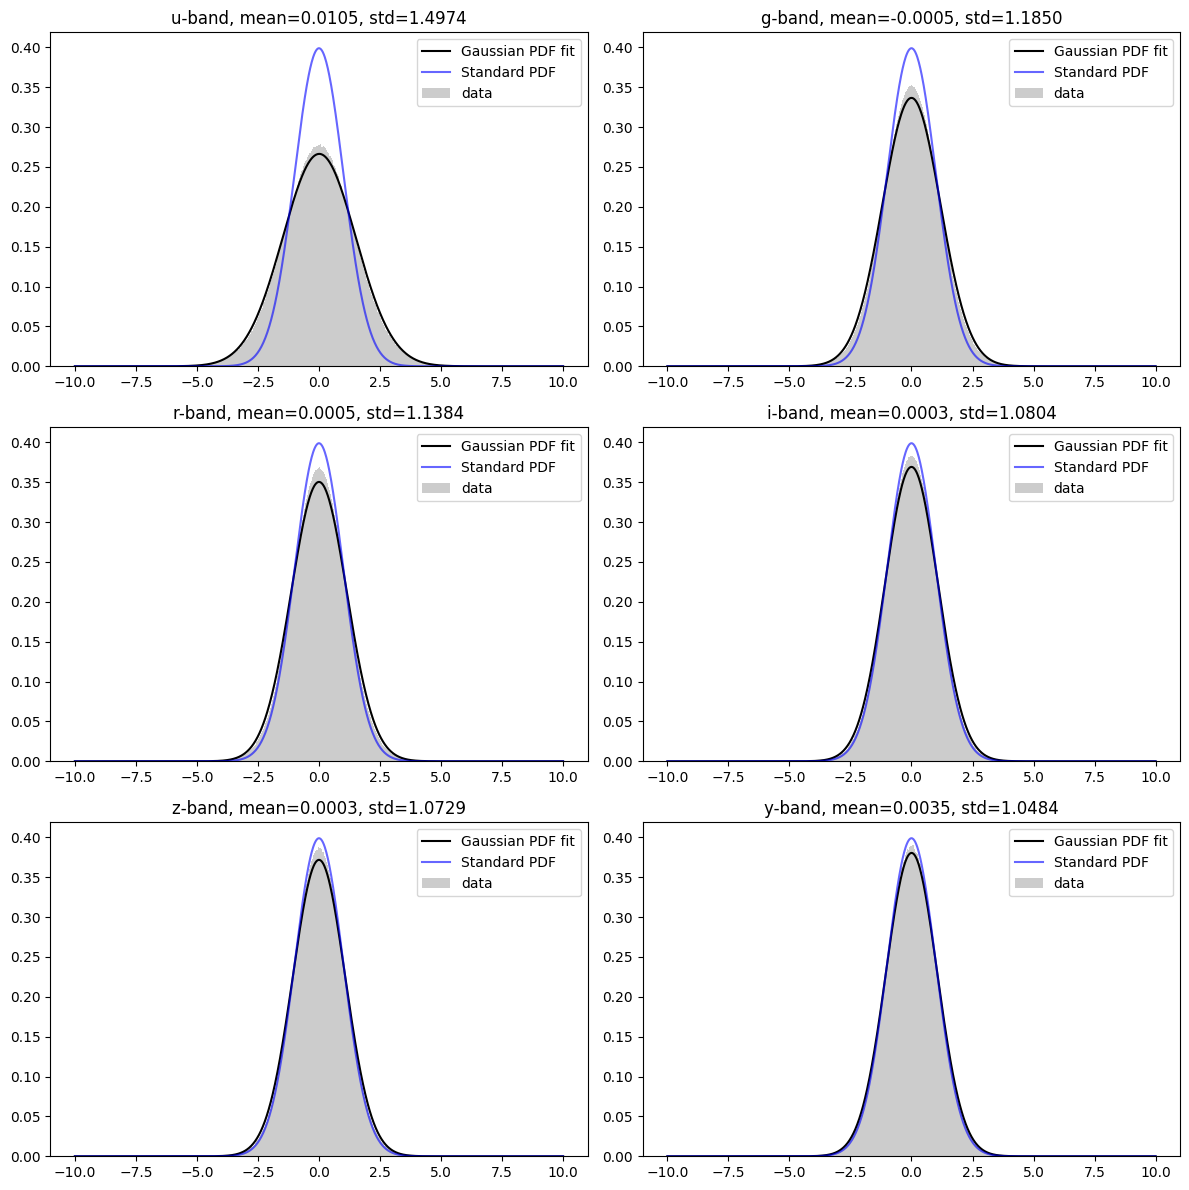

In [13]:
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np


def plot_hist(df, ax, band):
    counts = df["count"].to_numpy()

    probs = counts / np.sum(counts)

    mean = np.sum(probs * centers)
    std = np.sqrt(np.sum(probs * (centers - mean) ** 2))
    print(mean, std)

    ax.set_title(f"{band}-band, mean={mean:.4f}, std={std:.4f}")
    ax.bar(x=centers, height=probs / width, width=width, label="data", color="gray", alpha=0.4)
    ax.plot(bins, norm(loc=mean, scale=std).pdf(bins), label="Gaussian PDF fit", color="black", alpha=1.0)
    ax.plot(bins, norm(loc=0, scale=1).pdf(bins), label="Standard PDF", color="blue", alpha=0.6)
    ax.legend()


fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()

for i, band in enumerate(BANDS):
    try:
        df_band = per_band_hist_df.loc[band]
    except KeyError:
        continue
    plot_hist(df_band, axes[i], band)

plt.tight_layout()
plt.show()